In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!pip3 install transformers emoji==0.6.0 keras_nlp

In [26]:
!rm -r cil-sentiment/
!git clone https://github.com/carlosinator/cil-sentiment.git

Cloning into 'cil-sentiment'...
remote: Enumerating objects: 319, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 319 (delta 117), reused 152 (delta 94), pack-reused 128
Receiving objects: 100% (319/319), 2.60 MiB | 15.04 MiB/s, done.
Resolving deltas: 100% (173/173), done.


In [27]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras_nlp
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
import transformers
from transformers import AutoTokenizer, TFAutoModel, AutoConfig, TFAutoModelForSequenceClassification
import matplotlib.pyplot as plt
import pickle
import sys
sys.path.append("./cil-sentiment/")
sys.path.append("./")
from experiments import *

# Define experiments

In [41]:
BATCH_SIZE = 256

EXPERIMENTS = [
  Experiment(model_type='base',     hidden_dimension=0,   learning_rate=2e-5, epochs=5, batchsize=BATCH_SIZE),
  Experiment(model_type='read_gru', hidden_dimension=8,   learning_rate=1e-3, epochs=5, batchsize=BATCH_SIZE),
  Experiment(model_type='read_gru', hidden_dimension=64,  learning_rate=1e-3, epochs=5, batchsize=BATCH_SIZE),
  Experiment(model_type='read_gru', hidden_dimension=256, learning_rate=1e-3, epochs=5, batchsize=BATCH_SIZE),
  Experiment(model_type='minion',   hidden_dimension=8,   learning_rate=1e-3, epochs=5, batchsize=BATCH_SIZE),
  Experiment(model_type='minion',   hidden_dimension=64,  learning_rate=3e-4, epochs=5, batchsize=BATCH_SIZE),
  Experiment(model_type='minion',   hidden_dimension=256, learning_rate=3e-4, epochs=5, batchsize=BATCH_SIZE),
]

# Run experiments

In [5]:
# reproducibility
transformers.set_seed(0) # sets the seed in random, numpy, and tf

In [6]:
!gsutil cp "gs://cil_2023/train_pos_full_preprocessed_without_duplicates.txt" .
!gsutil cp "gs://cil_2023/train_neg_full_preprocessed_without_duplicates.txt" .

filename_train_pos = "train_pos_full_preprocessed_without_duplicates.txt"
filename_train_neg = "train_neg_full_preprocessed_without_duplicates.txt"
base_model_name = "vinai/bertweet-base"

Copying gs://cil_2023/train_pos_full_preprocessed_without_duplicates.txt...
- [1 files][ 74.6 MiB/ 74.6 MiB]   11.5 MiB/s                                   
Operation completed over 1 objects/74.6 MiB.                                     
Copying gs://cil_2023/train_neg_full_preprocessed_without_duplicates.txt...
| [1 files][ 91.6 MiB/ 91.6 MiB]   11.5 MiB/s                                   
Operation completed over 1 objects/91.6 MiB.                                     


In [7]:
# read dataset
dataset_pos_pd = pd.read_table(filename_train_pos, sep='\r\n', header=None, names=['text'])
dataset_neg_pd = pd.read_table(filename_train_neg, sep='\r\n', header=None, names=['text'])
dataset_pos_pd['label'] = 0
dataset_neg_pd['label'] = 1
dataset_pd = pd.concat([dataset_pos_pd, dataset_neg_pd])

# shuffle
dataset_pd = dataset_pd.sample(frac=1, random_state=0).reset_index(drop=True)

# tokenize data set
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
texts = tokenizer.batch_encode_plus(dataset_pd['text'].tolist(),
                                    padding=True, truncation=True,
                                    return_tensors='tf')

dataset = tf.data.Dataset.from_tensor_slices((dict(texts), dataset_pd['label']))

# split data set into training, validation, test
AUTOTUNE = tf.data.experimental.AUTOTUNE

val_data_size = test_data_size = int(0.1 * len(dataset_pd.index))
train_data_size = len(dataset_pd.index) - val_data_size - test_data_size

train_ds = dataset.take(train_data_size).batch(BATCH_SIZE, drop_remainder=True)
val_ds = dataset.skip(train_data_size).take(val_data_size).batch(BATCH_SIZE, drop_remainder=True)
test_ds = dataset.skip(train_data_size).skip(val_data_size).batch(BATCH_SIZE, drop_remainder=True)

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

<ipython-input-7-2231dfc60762>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset_pos_pd = pd.read_table(filename_train_pos, sep='\r\n', header=None, names=['text'])
<ipython-input-7-2231dfc60762>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset_neg_pd = pd.read_table(filename_train_neg, sep='\r\n', header=None, names=['text'])
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
for e in EXPERIMENTS:
  print("training {}".format(e.experiment_name))
  e.compile()
  e.train(train_ds, val_ds)

In [42]:
# loading already trained & saved models
for e in EXPERIMENTS:
  print("loading {}".format(e.experiment_name))
  e.load_model()

loading base_hdim0_lr2e-05_ep5_bs256
loading read_gru_hdim8_lr0.001_ep5_bs256
loading read_gru_hdim64_lr0.001_ep5_bs256
loading read_gru_hdim256_lr0.001_ep5_bs256
loading minion_hdim8_lr0.001_ep5_bs256
loading minion_hdim64_lr0.0003_ep5_bs256
loading minion_hdim256_lr0.0003_ep5_bs256


In [ ]:
# compute scorings (evaluation)
scorings = {}
for e in EXPERIMENTS:
  scorings[e.experiment_name] = e.evaluate(test_ds)

3/3 [==============================] - 9s 102ms/step


In [ ]:
# save scorings
with open("scorings.pkl", 'wb') as f:
  pickle.dump(scorings, f)
!gsutil mv ./scorings.pkl gs://cil_2023/final_models/

In [30]:
# load scorings
!gsutil cp gs://cil_2023/final_models/scorings.pkl .
with open("scorings.pkl", 'rb') as f:
  scorings = pickle.load(f)

Copying gs://cil_2023/final_models/scorings.pkl...
- [1 files][  6.2 KiB/  6.2 KiB]                                                
Operation completed over 1 objects/6.2 KiB.                                      


# Results

In [43]:
# Initialize lists for each column
df = pd.DataFrame(columns=[
    'model type', 'learning rate', 'hidden dimension', 'batch size', 'epochs', 'trainable parameters', 'trainable parameters (%)',
    'total parameters', 'accuracy', 'ACE', 'MCE', 'training duration (min)', 'average time per epoch (min)',
    'energy consumption (kWh)', 'power (kW)', 'average GPU memory usage (GiB)'
])

# fill table
for i, e in enumerate(EXPERIMENTS):
  df.loc[i] = [''] * len(df.columns)

  df.loc[i]['model type'] = e.model_type
  df.loc[i]['learning rate'] = '{:.1e}'.format(e.learning_rate)
  df.loc[i]['hidden dimension'] = e.hidden_dimension if not e.model_type == 'base' else 0
  df.loc[i]['batch size'] = e.batchsize
  df.loc[i]['epochs'] = e.epochs
  num_trainable_params = np.sum([tf.size(v) for v in e.model.trainable_variables])
  num_tot_params = e.model.count_params()
  df.loc[i]['trainable parameters'] = '{:,}'.format(num_trainable_params)
  df.loc[i]['trainable parameters (%)'] = '{:.2f}%'.format(100 * num_trainable_params / num_tot_params)
  df.loc[i]['total parameters'] = '{:,}'.format(num_tot_params)
  df.loc[i]['accuracy'] = '{:.4f}'.format(scorings[e.experiment_name]['accuracy'])
  df.loc[i]['ACE'] = '{:.4f}'.format(scorings[e.experiment_name]['ace'])
  df.loc[i]['MCE'] = '{:.4f}'.format(scorings[e.experiment_name]['mce'])
  duration_sec, _, _, average_time_per_epoch_sec = e.get_training_duration()
  df.loc[i]['training duration (min)'] = '{:.2f}'.format(duration_sec / 60)
  df.loc[i]['average time per epoch (min)'] = '{:.2f}'.format(average_time_per_epoch_sec / 60)
  energy = e.compute_energy_consumption_kWH()
  df.loc[i]['energy consumption (kWh)'] = '{:.2f}'.format(energy)
  df.loc[i]['power (kW)'] = '{:.2f}'.format(energy / (duration_sec / 3600))
  # Note: For the correct computation of the gpu memory usage, the colab session has to be restarted
  # before the training of each individual model so that the gpu memory cache is reset.
  df.loc[i]['average GPU memory usage (GiB)'] = '{:.2f}'.format(e.compute_average_gpu_memory_MiB() / 1024)


df

,model type,learning rate,hidden dimension,batch size,epochs,trainable parameters,trainable parameters (%),total parameters,accuracy,ACE,MCE,training duration (min),average time per epoch (min),energy consumption (kWh),power (kW),average GPU memory usage (GiB)
0,base,2.0e-05,0,256,5,"134,901,506",100.00%,"134,901,506",0.9042,0.0474,0.1311,214.00,42.80,1.39,0.39,33.05
1,read_gru,1.0e-03,8,256,5,"45,794",0.03%,"134,945,762",0.8938,0.0250,0.0733,147.17,29.43,0.80,0.33,5.22
2,read_gru,1.0e-03,64,256,5,"371,714",0.27%,"135,271,682",0.8971,0.0312,0.0947,148.50,29.70,0.85,0.34,9.17
3,read_gru,1.0e-03,256,256,5,"1,774,850",1.30%,"136,674,818",0.8979,0.0273,0.0952,164.33,32.87,0.99,0.36,17.07
4,minion,1.0e-03,8,256,5,"28,146",0.02%,"134,928,114",0.8969,0.0036,0.0391,115.67,23.13,0.72,0.37,5.25
5,minion,3.0e-04,64,256,5,"273,538",0.20%,"135,173,506",0.9015,0.0048,0.0235,128.33,25.67,0.79,0.37,5.25
6,minion,3.0e-04,256,256,5,"1,971,970",1.44%,"136,871,938",0.9033,0.0094,0.0500,155.33,31.07,0.97,0.37,9.23


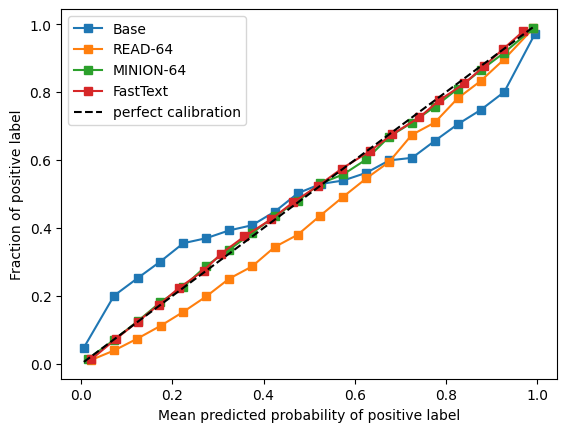

In [44]:
# draw calibration plots
type_to_name = {'base' : 'Base', 'read' : 'READ-64', 'read_gru' : 'READ-64', 'minion' : 'MINION-64'}
cal_data = [{"model_name" : type_to_name[e.model_type],
             "x" : scorings[e.experiment_name]["cal_curve_x"],
             "y" : scorings[e.experiment_name]["cal_curve_y"]}\
            for e in EXPERIMENTS if e.hidden_dimension == 64 or e.model_type == 'base']

# FastText (data copy-pasted from notebook FastTextModel.ipynb)
cal_data.append({"model_name" : "FastText",
                 "x" : np.array([0.02218998, 0.07582901, 0.12366667, 0.17092465, 0.21552878,
                                 0.26891807, 0.30734536, 0.35794256, 0.41649049, 0.4644345 ,
                                 0.52045998, 0.57190635, 0.63249314, 0.68189571, 0.74165221,
                                 0.78526172, 0.84066806, 0.88294175, 0.92480679, 0.96919469]),
                 "y" : np.array([0.01349279, 0.07309914, 0.12397817, 0.17468017, 0.2244868 ,
                                 0.27474767, 0.32487134, 0.3751626 , 0.42535926, 0.47507359,
                                 0.52492257, 0.5750102 , 0.62540634, 0.67538901, 0.72543974,
                                 0.77568665, 0.82549195, 0.87556404, 0.92582123, 0.97862502])})

for e in cal_data:
  plt.plot(e["x"], e["y"], label=e["model_name"], marker='s')
plt.plot(cal_data[0]["x"], cal_data[0]["x"], label="perfect calibration", linestyle='--', color='black')
plt.xlabel("Mean predicted probability of positive label")
plt.ylabel("Fraction of positive label")
plt.legend()
plt.show()
